In [3]:
%autosave 0
%matplotlib inline
import sys, os
%env KERAS_BACKEND=theano
%env THEANO_FLAGS=device=cuda3,floatX=float32,optimizer=fast_run

from collections import OrderedDict
from keras.layers import InputLayer, BatchNormalization, Dense, Conv2D, Deconv2D, Activation, Flatten, Reshape
import numpy as np
import pymc3 as pm
from theano import shared, config, function, clone, pp
import theano.tensor as tt
import keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from keras import backend as K
K.set_image_dim_ordering('th')

Autosave disabled
env: KERAS_BACKEND=theano
env: THEANO_FLAGS=device=cuda3,floatX=float32,optimizer=fast_run


In [4]:
import pymc3, theano
print(pymc3.__version__)
print(theano.__version__)
print(keras.__version__)

3.6
1.0.4
2.2.4


In [5]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
data = pm.floatX(x_train.reshape(-1, 1, 28, 28))
data /= np.max(data)

11493376/11490434 [==============================] - 2s 0us/step


In [10]:
data.size

47040000

In [11]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

def get_params(model):
    """Get parameters and updates from Keras model
    """
    shared_in_updates = list()
    params = list()
    updates = dict()

    for l in model.layers:
        attrs = dir(l)
        # Updates
        if 'updates' in attrs:
            updates.update(l.updates)
            shared_in_updates += [e[0] for e in l.updates]

        # Shared variables
        for attr_str in attrs:
            attr = getattr(l, attr_str)
            if isinstance(attr, tt.compile.SharedVariable):
                if attr is not model.get_input_at(0):
                    params.append(attr)

    return list(set(params) - set(shared_in_updates)), updates

# This code is required when using BatchNormalization layer
keras.backend.theano_backend._LEARNING_PHASE = \
    shared(np.uint8(1), name='keras_learning_phase')

In [12]:
def cnn_enc(xs, latent_dim, nb_filters=64, nb_conv=3, intermediate_dim=128):
    """Returns a CNN model of Keras.

    Parameters
    ----------
    xs : theano.TensorVariable
        Input tensor.
    latent_dim : int
        Dimension of latent vector.
    """
    input_layer = InputLayer(input_tensor=xs,
                             batch_input_shape=xs.tag.test_value.shape)
    model = Sequential()
    model.add(input_layer)

    cp1 = {'padding': 'same', 'activation': 'relu'}
    cp2 = {'padding': 'same', 'activation': 'relu', 'strides': (2, 2)}
    cp3 = {'padding': 'same', 'activation': 'relu', 'strides': (1, 1)}
    cp4 = cp3

    model.add(Conv2D(1, (2, 2), **cp1))
    model.add(Conv2D(nb_filters, (2, 2), **cp2))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), **cp3))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), **cp4))
    model.add(Flatten())
    model.add(Dense(intermediate_dim, activation='relu'))
    model.add(Dense(2 * latent_dim))

    return model

In [13]:
class Encoder:
    """Encode observed images to variational parameters (mean/std of Gaussian).

    Parameters
    ----------
    xs : theano.tensor.sharedvar.TensorSharedVariable
        Placeholder of input images.
    dim_hidden : int
        The number of hidden variables.
    net : Function
        Returns
    """
    def __init__(self, xs, dim_hidden, net):
        model = net(xs, dim_hidden)

        self.model = model
        self.xs = xs
        self.out = model.get_output_at(-1)
        self.means = self.out[:, :dim_hidden]
        self.rhos = self.out[:, dim_hidden:]
        self.params, self.updates = get_params(model)
        self.enc_func = None
        self.dim_hidden = dim_hidden

    def _get_enc_func(self):
        if self.enc_func is None:
            xs = tt.tensor4()
            means = clone(self.means, {self.xs: xs})
            rhos = clone(self.rhos, {self.xs: xs})
            self.enc_func = function([xs], [means, rhos])

        return self.enc_func

    def encode(self, xs):
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        enc_func = self._get_enc_func()
        means, _ = enc_func(xs)

        return means

    def draw_samples(self, xs, n_samples=1):
        """Draw samples of hidden variables based on variational parameters encoded.

        Parameters
        ----------
        xs : numpy.ndarray, shape=(n_images, 1, height, width)
            Images.
        """
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        enc_func = self._get_enc_func()
        means, rhos = enc_func(xs)
        means = np.repeat(means, n_samples, axis=0)
        rhos = np.repeat(rhos, n_samples, axis=0)
        ns = np.random.randn(len(xs) * n_samples, self.dim_hidden)
        zs = means + pm.distributions.dist_math.rho2sd(rhos) * ns

        return zs

In [18]:
def cnn_dec(zs, nb_filters=64, nb_conv=3, output_shape=(1, 28, 28)):
    """Returns a CNN model of Keras.

    Parameters
    ----------
    zs : theano.tensor.var.TensorVariable
        Input tensor.
    """
    minibatch_size, dim_hidden = zs.tag.test_value.shape
    input_layer = InputLayer(input_tensor=zs,
                             batch_input_shape=zs.tag.test_value.shape)
    model = Sequential()
    model.add(input_layer)

    model.add(Dense(dim_hidden, activation='relu'))
    model.add(Dense(nb_filters * 14 * 14, activation='relu'))

    cp1 = {'padding': 'same', 'activation': 'relu', 'strides': (1, 1)}
    cp2 = cp1
    cp3 = {'padding': 'valid', 'activation': 'relu', 'strides': (2, 2)}
    cp4 = {'padding': 'same',  'activation': 'sigmoid'}

    output_shape_ = (minibatch_size, nb_filters, 14, 14)
    model.add(Reshape(output_shape_[1:]))
    model.add(Deconv2D(nb_filters, (nb_conv, nb_conv), data_format='channels_first', **cp1))
    model.add(Deconv2D(nb_filters, (nb_conv, nb_conv), data_format='channels_first', **cp2))
    output_shape_ = (minibatch_size, nb_filters, 29, 29)
    model.add(Deconv2D(nb_filters, (2, 2), data_format='channels_first', **cp3))
    model.add(Conv2D(1, (2, 2), **cp4))

    return model

In [14]:
class Decoder:
    """Decode hidden variables to images.

    Parameters
    ----------
    zs : Theano tensor
        Hidden variables.
    """
    def __init__(self, zs, net):
        model = net(zs)
        self.model = model
        self.zs = zs
        self.out = model.get_output_at(-1)
        self.params, self.updates = get_params(model)
        self.dec_func = None

    def _get_dec_func(self):
        if self.dec_func is None:
            zs = tt.matrix()
            xs = clone(self.out, {self.zs: zs})
            self.dec_func = function([zs], xs)

        return self.dec_func

    def decode(self, zs):
        """Decode hidden variables to images.

        An image consists of the mean parameters of the observation noise.

        Parameters
        ----------
        zs : numpy.ndarray, shape=(n_samples, dim_hidden)
            Hidden variables.
        """
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        return self._get_dec_func()(zs)

In [15]:
minibatch_size = 100
dim_hidden = 2

In [16]:
xs_t = tt.tensor4(name='xs_t')
xs_t.tag.test_value = np.zeros((minibatch_size, 1, 28, 28)).astype('float32')
# Encoder
enc = Encoder(xs_t, dim_hidden, net=cnn_enc)
enc.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 1, 28, 28)          5         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 64, 14, 14)         320       
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (100, 64, 14, 14)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (100, 12544)              0         
_________________________________________________________________
dense_1 (Dense)              (100, 128)                1605760   
_________________________________________________________________
dense_2 (Dense)              (100, 4)                  516       
Total para

In [19]:
with pm.Model() as model:
    # Hidden variables
    zs = pm.Normal('zs', mu=0, sd=1, shape=(minibatch_size, dim_hidden), dtype='float32', total_size=len(data))

    # Decoder and its parameters
    dec = Decoder(zs, net=cnn_dec)

    # Observation model
    xs_ = pm.Normal('xs_', mu=dec.out, sd=0.1, observed=xs_t, dtype='float32', total_size=len(data))

In [20]:
local_RVs = OrderedDict({zs: dict(mu=enc.means, rho=enc.rhos)})

In [21]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (100, 2)                  6         
_________________________________________________________________
dense_4 (Dense)              (100, 12544)              37632     
_________________________________________________________________
reshape_1 (Reshape)          (100, 64, 14, 14)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (100, 64, 14, 14)         36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (100, 64, 28, 28)         16448     
_________________________________________________________________
conv2d_5 (Conv2D)            (100, 1, 28, 28)          257       
Total para

In [24]:
xs_t_minibatch = pm.Minibatch(data, minibatch_size)

with model:
    approx = pm.fit(
        1500,
        local_rv=local_RVs,
        more_obj_params=enc.params + dec.params,
        obj_optimizer=pm.rmsprop(learning_rate=0.001),
        more_replacements={xs_t:xs_t_minibatch},
    )

Average Loss = 62,468: 100%|██████████| 1500/1500 [20:29<00:00,  1.37s/it]
Finished [100%]: Average Loss = 62,316


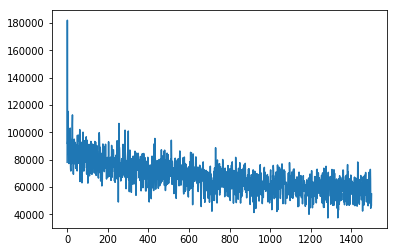

In [25]:
plt.plot(approx.hist);

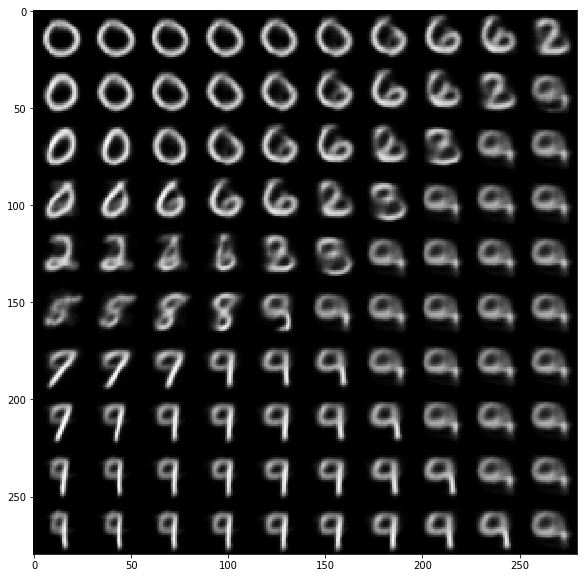

In [26]:

nn = 10
zs = np.array([(z1, z2)
               for z1 in np.linspace(-2, 2, nn)
               for z2 in np.linspace(-2, 2, nn)]).astype('float32')
xs = dec.decode(zs)[:, 0, :, :]
xs = np.bmat([[xs[i + j * nn] for i in range(nn)] for j in range(nn)])
matplotlib.rc('axes', **{'grid': False})
plt.figure(figsize=(10, 10))
plt.imshow(xs, interpolation='none', cmap='gray')
plt.show()

